# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10129009031653136864
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5011865030438017190
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 00:37:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'VGG16'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 7
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4", "S5", "S6"
T_all_labels = "T0", "T1", "T2", "T3", "T4", "T5", "T6"

#base_path = ''
base_path = 'gdrive/My Drive/Research_7_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_VGG16_None S_VGG16_imagenet T_VGG16_None T_VGG16_imagenet


['S_VGG16_imagenet', 'S_VGG16_None', 'T_VGG16_imagenet', 'T_VGG16_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 1)
(786, 128, 128, 3) (786, 1)
(786, 128, 128, 3) (786, 1)

(2598, 128, 128, 3) (2598, 1)
(866, 128, 128, 3) (866, 1)
(866, 128, 128, 3) (866, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2358, 128, 128, 3) (2358, 7)
(786, 128, 128, 3) (786, 7)
(786, 128, 128, 3) (786, 7)

(2598, 128, 128, 3) (2598, 7)
(866, 128, 128, 3) (866, 7)
(866, 128, 128, 3) (866, 7)


## 2-2. Image Check

xTrain_S image Numbers :  2358
xTrain_S image Numbers // 10 :  235
11


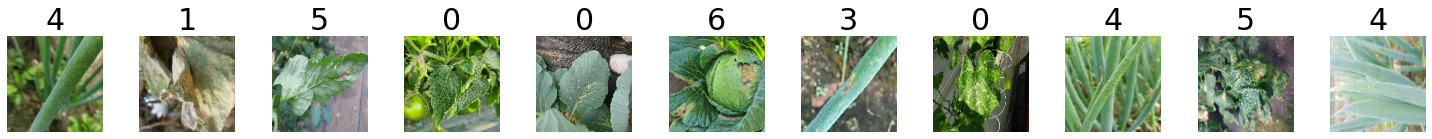

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2598
xTrain_S image Numbers // 10 :  259
11


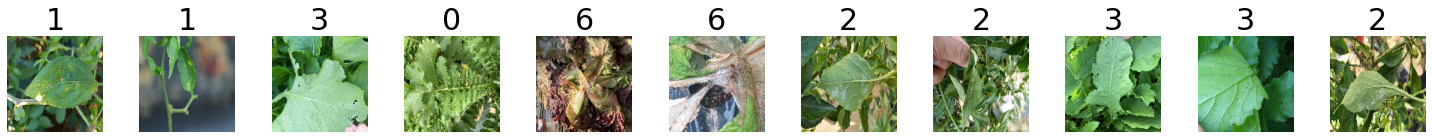

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 21s 249ms/step - loss: 1.9270 - accuracy: 0.2969 - val_loss: 1.8600 - val_accuracy: 0.3053
Epoch 2/100
37/37 [==============================] - 5s 144ms/step - loss: 1.8178 - accuracy: 0.3053 - val_loss: 1.7601 - val_accuracy: 0.3053
Epoch 3/100
37/37 [==============================] - 5s 144ms/step - loss: 1.7748 - accuracy: 0.3053 - val_loss: 1.7257 - val_accuracy: 0.3053
Epoch 4/100
37/37 [==============================] - 5s 144ms/step - loss: 1.7667 - accuracy: 0.3053 - val_loss: 1.7407 - val_accuracy: 0.3053
Epoch 5/100
37/37 [==============================] - 5s 145ms/step - loss: 1.6426 - accuracy: 0.3868 - val_loss: 1.5854 - val_accuracy: 0.4326
Epoch 6/100
37/37 [==============================] - 5s 144ms/step - loss: 1.5619 - accuracy: 0.4330 - val_loss: 1.7045 - val_accuracy: 0.3206
Epoch 7/100
37/37 [==============================] - 5s 145ms/step - loss: 1.5119 - accuracy: 0.4466 - val_loss: 1.4506 - val_accuracy: 0.464

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.926997,0.296862,1.859981,0.305344
1,1.817849,0.305344,1.760101,0.305344
2,1.774828,0.305344,1.725681,0.305344
3,1.766744,0.305344,1.740680,0.305344
4,1.642638,0.386768,1.585398,0.432570
...,...,...,...,...
93,0.000171,1.000000,1.680323,0.818066
94,0.000086,1.000000,2.211044,0.811705
95,0.000064,1.000000,1.746788,0.815522
96,0.000072,1.000000,1.838457,0.814249


Minimum validation loss: 0.7157920598983765
Maximum validation accuracy: 0.8244274854660034


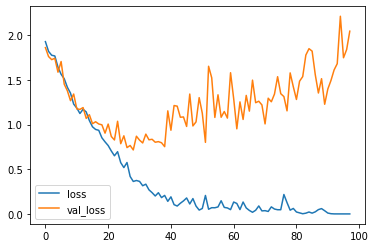

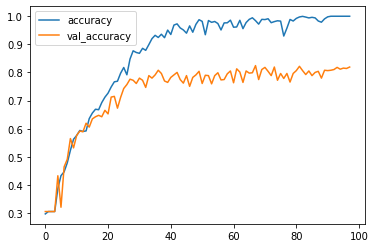

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
25/25 [==============================] - 2s 22ms/step - loss: 1.1661 - accuracy: 0.8270
test loss, test acc: [1.1661375761032104, 0.8269720077514648]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

25/25 [==============================] - 1s 21ms/step


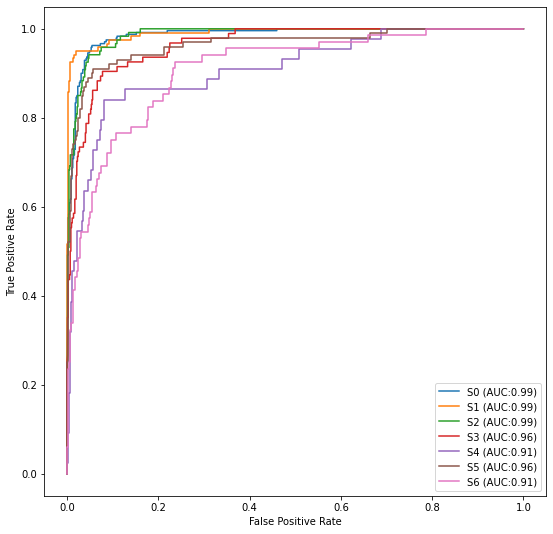

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
37/37 [==============================] - 7s 155ms/step - loss: 2.5304 - accuracy: 0.2651 - val_loss: 1.8334 - val_accuracy: 0.3053
Epoch 2/100
37/37 [==============================] - 5s 146ms/step - loss: 1.7872 - accuracy: 0.3142 - val_loss: 1.7003 - val_accuracy: 0.3359
Epoch 3/100
37/37 [==============================] - 5s 145ms/step - loss: 1.6623 - accuracy: 0.3668 - val_loss: 1.9160 - val_accuracy: 0.3588
Epoch 4/100
37/37 [==============================] - 5s 145ms/step - loss: 1.6220 - accuracy: 0.3965 - val_loss: 1.5167 - val_accuracy: 0.4606
Epoch 5/100
37/37 [==============================] - 5s 145ms/step - loss: 1.4986 - accuracy: 0.4444 - val_loss: 1.6342 - val_accuracy: 0.3639
Epoch 6/100
37/37 [==============================] - 5s 146ms/step - loss: 1.4243 - accuracy: 0.4784 - val_loss: 1.2099 - val_accuracy: 0.5636
Epoch 7/100
37/37 [==============================] - 5s 144ms/step - loss: 1.9051 - accuracy: 0.3308 - val_loss: 1.7246 - val_accuracy: 0.3104

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,2.530364,0.265055,1.833389,0.305344
1,1.787196,0.314249,1.700295,0.335878
2,1.662335,0.366836,1.916020,0.358779
3,1.622029,0.396522,1.516737,0.460560
4,1.498587,0.444444,1.634170,0.363868
...,...,...,...,...
60,0.051353,0.983885,1.463830,0.735369
61,0.057999,0.984733,1.457657,0.730280
62,0.034351,0.988974,1.494475,0.751908
63,0.039976,0.987701,1.700995,0.720102


Minimum validation loss: 0.8262569308280945
Maximum validation accuracy: 0.7773537039756775


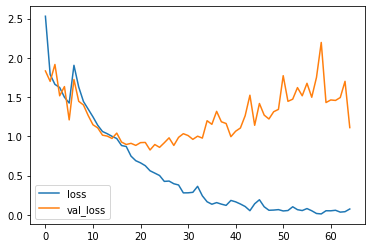

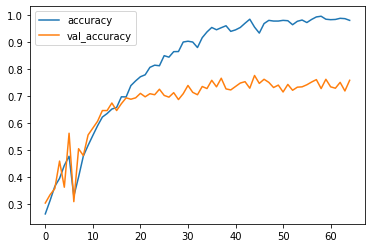

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
25/25 [==============================] - 1s 22ms/step - loss: 1.2549 - accuracy: 0.7354
test loss, test acc: [1.2549277544021606, 0.7353689670562744]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

25/25 [==============================] - 1s 20ms/step


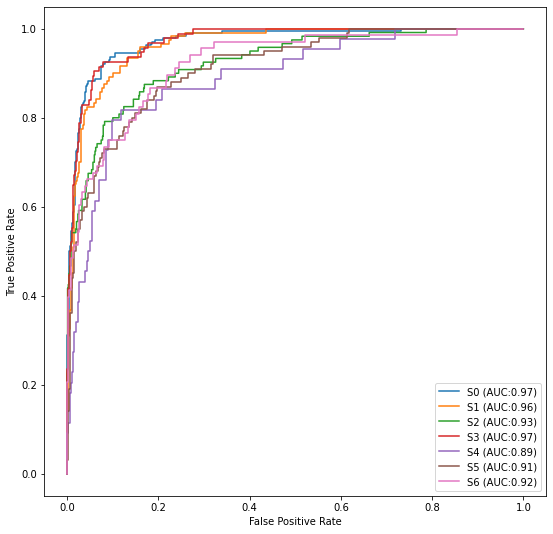

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 11s 239ms/step - loss: 3.0062 - accuracy: 0.2737 - val_loss: 1.8241 - val_accuracy: 0.2771
Epoch 2/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8343 - accuracy: 0.2771 - val_loss: 1.8216 - val_accuracy: 0.2771
Epoch 3/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8249 - accuracy: 0.2771 - val_loss: 1.8259 - val_accuracy: 0.2771
Epoch 4/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8255 - accuracy: 0.2771 - val_loss: 1.8231 - val_accuracy: 0.2771
Epoch 5/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8250 - accuracy: 0.2771 - val_loss: 1.8230 - val_accuracy: 0.2771
Epoch 6/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8242 - accuracy: 0.2771 - val_loss: 1.8220 - val_accuracy: 0.2771
Epoch 7/100
41/41 [==============================] - 6s 143ms/step - loss: 1.8239 - accuracy: 0.2771 - val_loss: 1.8277 - val_accuracy: 0.277

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,3.006235,0.273672,1.824070,0.277136
1,1.834253,0.277136,1.821579,0.277136
2,1.824850,0.277136,1.825874,0.277136
3,1.825467,0.277136,1.823097,0.277136
4,1.824972,0.277136,1.822980,0.277136
5,1.824181,0.277136,1.822006,0.277136
6,1.823876,0.277136,1.827702,0.277136
7,1.824499,0.277136,1.824176,0.277136
8,1.820892,0.277136,1.836169,0.277136
9,1.831275,0.277136,1.821899,0.277136


Minimum validation loss: 1.8213425874710083
Maximum validation accuracy: 0.27713626623153687


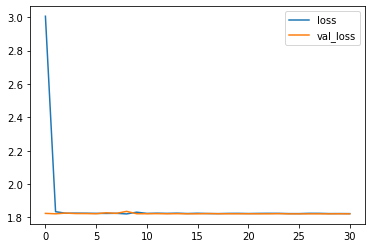

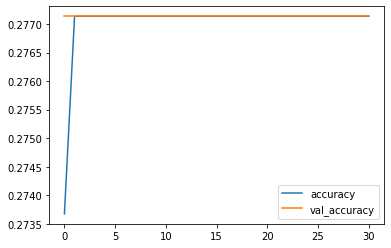

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
28/28 [==============================] - 1s 30ms/step - loss: 1.8241 - accuracy: 0.2771
test loss, test acc: [1.8240700960159302, 0.27713626623153687]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

28/28 [==============================] - 1s 20ms/step


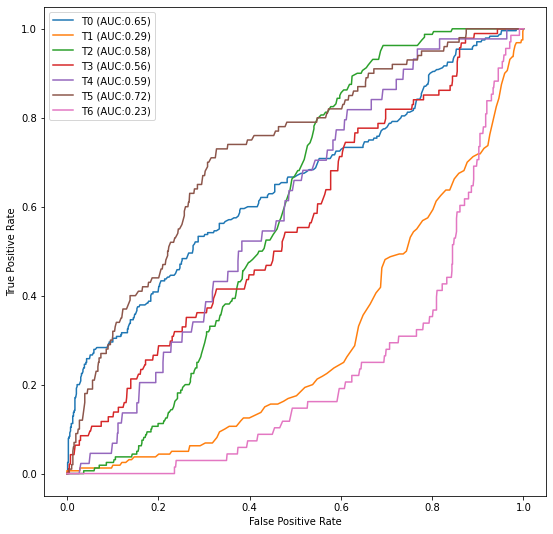

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
41/41 [==============================] - 7s 152ms/step - loss: 2.1923 - accuracy: 0.2375 - val_loss: 1.8139 - val_accuracy: 0.2771
Epoch 2/100
41/41 [==============================] - 6s 144ms/step - loss: 1.7340 - accuracy: 0.3006 - val_loss: 1.5661 - val_accuracy: 0.3637
Epoch 3/100
41/41 [==============================] - 6s 144ms/step - loss: 1.6122 - accuracy: 0.3345 - val_loss: 1.4711 - val_accuracy: 0.4065
Epoch 4/100
41/41 [==============================] - 6s 144ms/step - loss: 1.4751 - accuracy: 0.4042 - val_loss: 1.4144 - val_accuracy: 0.4157
Epoch 5/100
41/41 [==============================] - 6s 143ms/step - loss: 1.4345 - accuracy: 0.4461 - val_loss: 1.4527 - val_accuracy: 0.4053
Epoch 6/100
41/41 [==============================] - 6s 144ms/step - loss: 1.3715 - accuracy: 0.4727 - val_loss: 1.3208 - val_accuracy: 0.4550
Epoch 7/100
41/41 [==============================] - 6s 144ms/step - loss: 1.3593 - accuracy: 0.4681 - val_loss: 1.2783 - val_accuracy: 0.4954

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,2.192272,0.237490,1.813888,0.277136
1,1.733999,0.300616,1.566125,0.363741
2,1.612217,0.334488,1.471134,0.406467
3,1.475091,0.404157,1.414397,0.415704
4,1.434459,0.446112,1.452729,0.405312
...,...,...,...,...
82,0.096267,0.971901,0.686864,0.839492
83,0.049390,0.983834,0.708711,0.826790
84,0.022903,0.991917,0.750507,0.826790
85,0.020134,0.996536,0.861433,0.830254


Minimum validation loss: 0.43911609053611755
Maximum validation accuracy: 0.8591223955154419


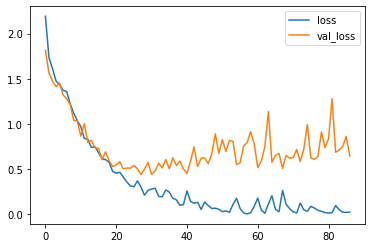

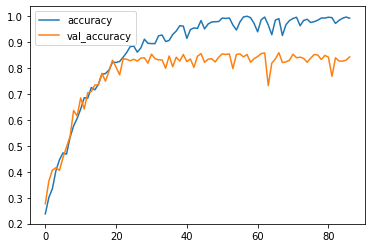

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
28/28 [==============================] - 1s 22ms/step - loss: 0.7075 - accuracy: 0.8453
test loss, test acc: [0.7075330018997192, 0.8452655673027039]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

28/28 [==============================] - 1s 20ms/step


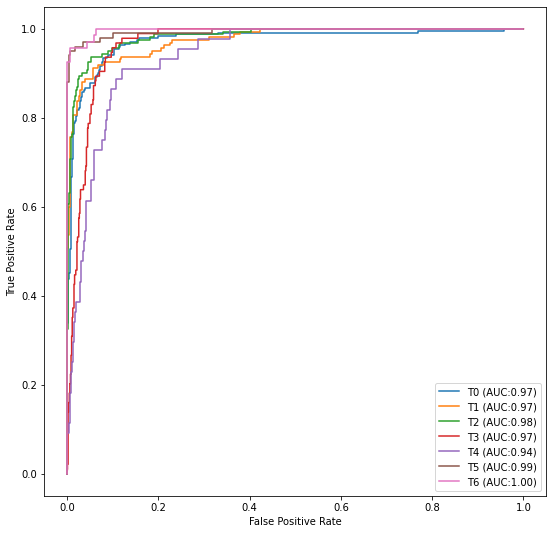

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_VGG16_None
test loss, test acc: [1.1661375761032104, 0.8269720077514648]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_VGG16_imagenet
test loss, test acc: [1.2549277544021606, 0.7353689670562744]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_VGG16_None
test loss, test acc: [1.8240700960159302, 0.27713626623153687]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_VGG16_imagenet
test loss, test acc: [0.7075330018997192, 0.8452655673027039]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_VGG16_None →→→ Target Test
28/28 [==============================] - 1s 22ms/step - loss: 9.1081 - accuracy: 0.1848
test loss, test acc: [9.108059883117676, 0.18475750088691711]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_VGG16_imagenet →→→ Target Test
28/28 [==============================] - 1s 22ms/step - loss: 6.1786 - accuracy: 0.1928
test loss, test acc: [6.178623676300049, 0.19284065067768097]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_VGG16_None →→→ Source Test
25/25 [==============================] - 1s 22ms/step - loss: 1.8362 - accuracy: 0.3053
test loss, test acc: [1.8362221717834473, 0.30534350872039795]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_VGG16_imagenet →→→ Source Test
25/25 [==============================] - 1s 22ms/step - loss: 8.4216 - accuracy: 0.2163
test loss, test acc: [8.421646118164062, 0.21628499031066895]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )